# SVD Movie Recommendation System
## Συστήματα Συστάσεων Ταινιών με Αποσύνθεση Μοναδικών Τιμών

### Πτυχιακή Εργασία - Movie Recommendation System using Singular Value Decomposition

Αυτό το notebook υλοποιεί ένα ολοκληρωμένο σύστημα συστάσεων ταινιών χρησιμοποιώντας την τεχνική SVD (Singular Value Decomposition) για collaborative filtering. Το σύστημα περιλαμβάνει:

- **Αντικειμενοστρεφή σχεδίαση (Object-Oriented Design)**
- **Πλήρη ανάλυση δεδομένων με visualizations**
- **Evaluation metrics (RMSE, MAE, Coverage, Precision)**
- **Δημιουργία 10 προτάσεων ταινιών**
- **Στατιστικές αναλύσεις και γραφήματα με matplotlib**

## 1. Εισαγωγή Βιβλιοθηκών

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import urllib.request
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')

## 2. Κλάση SVD Movie Recommender

Υλοποίηση του συστήματος συστάσεων με αντικειμενοστρεφή προσέγγιση

In [95]:
class SVDMovieRecommender:
    def __init__(self, n_factors=50, random_state=42):
        """
        Αρχικοποίηση του SVD Movie Recommender

        Parameters:
        -----------
        n_factors : int, default=50
            Αριθμός latent factors για SVD decomposition
        random_state : int, default=42
            Random state για reproducibility
        """
        self.n_factors = n_factors
        self.random_state = random_state
        self.ratings_df = None
        self.movies_df = None
        self.user_item_matrix = None
        self.user_ratings_mean = None
        self.predictions_df = None
        self.U = None
        self.sigma = None
        self.Vt = None
        self.train_data = None
        self.test_data = None

        # Αποθήκευση evaluation metrics
        self.rmse_score = None
        self.mae_score = None
        self.coverage = None

        print(f"SVD Movie Recommender αρχικοποιήθηκε με {n_factors} factors")

## 3. Εισαγωγή Δεδομένων

In [96]:
class SVDMovieRecommender(SVDMovieRecommender):    
    def load_movielens_data(self, data_dir):
            self.data_dir = data_dir
            self.load_data(self.data_dir)

    def load_data(self, data_dir):
        """
        Load MovieLens data από αρχεία

        Parameters:
        -----------
        data_dir : str, default='ml-100k'
            Directory που περιέχει το dataset files
        """
        data_dir = self.data_dir
        
        # Load ratings data
        ratings_file = os.path.join(data_dir, 'u.data')
        self.ratings_df = pd.read_csv(ratings_file, sep='\t', 
                                    names=['userId', 'movieId', 'rating', 'timestamp'])
        
        initial_rows = len(self.ratings_df)
        self.ratings_df = self.ratings_df.drop_duplicates(subset=['userId', 'movieId'])
        duplicates_removed = initial_rows - len(self.ratings_df)
        if duplicates_removed > 0:
            print(f"Αφαιρέθηκαν {duplicates_removed} διπλότυπα ratings για μοναδικότητα.")

        # Load movies data
        movies_file = os.path.join(data_dir, 'u.item')
        self.movies_df = pd.read_csv(movies_file, sep='|', encoding='latin-1',
                                    names=['movieId', 'title', 'release_date', 'video_release_date',
                                            'imdb_url'] + [f'genre_{i}' for i in range(19)],
                                    usecols=['movieId', 'title'])

        print("Δεδομένα φορτώθηκαν με επιτυχία!")
        print(f"Ratings shape: {self.ratings_df.shape}")
        print(f"Movies shape: {self.movies_df.shape}")

## 4. Εξερεύνηση Δεδομένων

In [97]:
class SVDMovieRecommender(SVDMovieRecommender):    
    def explore_data(self):
            """
            Εκτέλεση exploratory data analysis και επιστροφή summary statistics
            """
            if self.ratings_df is None:
                raise ValueError("Δεδομένα δεν έχουν φορτωθεί. Παρακαλώ εκτελέστε load_data() πρώτα.")

            print("=== ΕΞΕΡΕΥΝΗΣΗ ΔΕΔΟΜΕΝΩΝ ===")
            print(f"Συνολικές αξιολογήσεις: {len(self.ratings_df):,}")
            print(f"Αριθμός χρηστών: {self.ratings_df['userId'].nunique():,}")
            print(f"Αριθμός ταινιών: {self.ratings_df['movieId'].nunique():,}")
            print(f"Κλίμακα αξιολόγησης: {self.ratings_df['rating'].min()} - {self.ratings_df['rating'].max()}")
            print(f"Μέση αξιολόγηση: {self.ratings_df['rating'].mean():.2f}")
            print(f"Sparsity δεδομένων: {(1 - len(self.ratings_df) / (self.ratings_df['userId'].nunique() * self.ratings_df['movieId'].nunique())) * 100:.2f}%")

            # Κατανομή αξιολογήσεων
            rating_counts = self.ratings_df['rating'].value_counts().sort_index()
            print("\nΚατανομή Αξιολογήσεων:")
            for rating, count in rating_counts.items():
                print(f"  {rating} αστέρια: {count:,} ({count/len(self.ratings_df)*100:.1f}%)")

            return {
                'total_ratings': len(self.ratings_df),
                'n_users': self.ratings_df['userId'].nunique(),
                'n_movies': self.ratings_df['movieId'].nunique(),
                'avg_rating': self.ratings_df['rating'].mean(),
                'rating_distribution': rating_counts,
                'sparsity': (1 - len(self.ratings_df) / (self.ratings_df['userId'].nunique() * self.ratings_df['movieId'].nunique()))
            }

## 5. Προ-επεξεργιασία Δεδομένων

In [98]:
class SVDMovieRecommender(SVDMovieRecommender):    
    def prepare_matrix(self, min_ratings_per_user=5, min_ratings_per_movie=5):
            """
            Προετοιμασία user-item rating matrix για SVD

            Parameters:
            -----------
            min_ratings_per_user : int, default=5
                Ελάχιστος αριθμός ratings ανά χρήστη για να συμπεριληφθεί
            min_ratings_per_movie : int, default=5
                Ελάχιστος αριθμός ratings ανά ταινία για να συμπεριληφθεί
            """
            if self.ratings_df is None:
                raise ValueError("Δεδομένα δεν έχουν φορτωθεί. Παρακαλώ εκτελέστε load_data() πρώτα.")

            print("Προετοιμασία user-item matrix...")

            # Φιλτράρισμα χρηστών και ταινιών με ελάχιστες αξιολογήσεις
            user_counts = self.ratings_df['userId'].value_counts()
            movie_counts = self.ratings_df['movieId'].value_counts()

            valid_users = user_counts[user_counts >= min_ratings_per_user].index
            valid_movies = movie_counts[movie_counts >= min_ratings_per_movie].index

            filtered_ratings = self.ratings_df[
                (self.ratings_df['userId'].isin(valid_users)) & 
                (self.ratings_df['movieId'].isin(valid_movies))
            ].copy()

            initial_filtered = len(filtered_ratings)
            filtered_ratings = filtered_ratings.drop_duplicates(subset=['userId', 'movieId'])
            duplicates_in_filtered = initial_filtered - len(filtered_ratings)
            if duplicates_in_filtered > 0:
                print(f"Αφαιρέθηκαν {duplicates_in_filtered} duplicates από filtered data.")
            
            print(f"Φιλτράρισμα από {len(self.ratings_df)} σε {len(filtered_ratings)} ratings")
            print(f"Χρήστες: {self.ratings_df['userId'].nunique()} -> {filtered_ratings['userId'].nunique()}")
            print(f"Ταινίες: {self.ratings_df['movieId'].nunique()} -> {filtered_ratings['movieId'].nunique()}")

            # Δημιουργία user-item matrix
            self.user_item_matrix = filtered_ratings.pivot(index='userId', 
                                                        columns='movieId', 
                                                        values='rating').fillna(0)

            # Υπολογισμός user rating means (για centering)
            self.user_ratings_mean = np.array(filtered_ratings.groupby('userId')['rating'].mean())

            print(f"User-item matrix shape: {self.user_item_matrix.shape}")
            print(f"Matrix sparsity: {(1 - np.count_nonzero(self.user_item_matrix) / self.user_item_matrix.size) * 100:.2f}%")

            return self.user_item_matrix

    def split_data(self, test_size=0.2):
        """
        Διαχωρισμός δεδομένων σε training και testing sets

        Parameters:
        -----------
        test_size : float, default=0.2
            Αναλογία δεδομένων για testing
        """
        if self.ratings_df is None:
            raise ValueError("Δεδομένα δεν έχουν φορτωθεί. Παρακαλώ εκτελέστε load_data() πρώτα.")

        self.train_data, self.test_data = train_test_split(
            self.ratings_df, 
            test_size=test_size, 
            random_state=self.random_state,
            stratify=self.ratings_df['rating']
        )

        print(f"Διαχωρισμός δεδομένων: {len(self.train_data)} training, {len(self.test_data)} testing")
        return self.train_data, self.test_data

## 6. SVD Train

In [99]:
class SVDMovieRecommender(SVDMovieRecommender):    
    def train_svd(self):
            """
            Εκπαίδευση του SVD model στο user-item matrix
            """
            if self.user_item_matrix is None:
                raise ValueError("User-item matrix δεν έχει προετοιμαστεί. Παρακαλώ εκτελέστε prepare_matrix() πρώτα.")

            print(f"Εκπαίδευση SVD model με {self.n_factors} factors...")

            # Κεντράρισμα του matrix αφαιρώντας τους user means
            user_ratings_mean = self.user_item_matrix.mean(axis=1)
            user_item_matrix_centered = self.user_item_matrix.sub(user_ratings_mean, axis=0)

            # Μετατροπή σε numpy array για SVD
            matrix_array = user_item_matrix_centered.values

            # Χειρισμός της περίπτωσης όπου k είναι πολύ μεγάλο
            max_k = min(matrix_array.shape) - 1
            k = min(self.n_factors, max_k)

            if k != self.n_factors:
                print(f"Μείωση factors από {self.n_factors} σε {k} λόγω διαστάσεων matrix")
                self.n_factors = k

            # Εκτέλεση SVD
            self.U, self.sigma, self.Vt = svds(matrix_array, k=k, random_state=self.random_state)

            # Ταξινόμηση κατά singular values (φθίνουσα)
            idx = np.argsort(self.sigma)[::-1]
            self.U = self.U[:, idx]
            self.sigma = self.sigma[idx]
            self.Vt = self.Vt[idx, :]

            # Δημιουργία diagonal matrix από sigma
            sigma_diag = np.diag(self.sigma)

            # Ανακατασκευή του matrix
            reconstructed_matrix = np.dot(np.dot(self.U, sigma_diag), self.Vt)

            # Επαναφορά user means
            self.predictions_df = pd.DataFrame(
                reconstructed_matrix + user_ratings_mean.values.reshape(-1, 1),
                index=self.user_item_matrix.index,
                columns=self.user_item_matrix.columns
            )

            # Περιορισμός predictions σε έγκυρο εύρος αξιολογήσεων
            self.predictions_df = self.predictions_df.clip(1, 5)

            print("SVD model εκπαιδεύτηκε με επιτυχία!")

            # Υπολογισμός explained variance
            original_variance = np.var(matrix_array[matrix_array != 0])
            explained_variance_ratio = np.sum(self.sigma**2) / (original_variance * np.count_nonzero(matrix_array))
            print(f"Explained variance ratio: {explained_variance_ratio:.4f}")

            return self.predictions_df

## 6. Αξιολόγηση Μοντέλου

In [100]:
class SVDMovieRecommender(SVDMovieRecommender):    
    def calculate_rmse(self, predictions, actuals):
            """
            Υπολογισμός Root Mean Square Error

            Parameters:
            -----------
            predictions : array-like
                Predicted ratings
            actuals : array-like
                Actual ratings

            Returns:
            --------
            float : RMSE value
            """
            return np.sqrt(mean_squared_error(actuals, predictions))

    def calculate_mae(self, predictions, actuals):
        """
        Υπολογισμός Mean Absolute Error

        Parameters:
        -----------
        predictions : array-like
            Predicted ratings
        actuals : array-like
            Actual ratings

        Returns:
        --------
        float : MAE value
        """
        return mean_absolute_error(actuals, predictions)

    def evaluate_model(self):
        """
        Αξιολόγηση του εκπαιδευμένου model χρησιμοποιώντας διάφορα metrics
        """
        if self.predictions_df is None:
            raise ValueError("Model δεν έχει εκπαιδευτεί. Παρακαλώ εκτελέστε train_svd() πρώτα.")

        if self.test_data is None:
            print("Δεν υπάρχουν test data. Χρησιμοποιώ training data για αξιολόγηση.")
            test_data = self.train_data if self.train_data is not None else self.ratings_df
        else:
            test_data = self.test_data

        print("Αξιολόγηση απόδοσης μοντέλου...")

        # Λήψη predictions για test data
        predictions = []
        actuals = []

        for _, row in test_data.iterrows():
            user_id = row['userId']
            movie_id = row['movieId']
            actual_rating = row['rating']

            try:
                predicted_rating = self.predictions_df.loc[user_id, movie_id]
                predictions.append(predicted_rating)
                actuals.append(actual_rating)
            except (KeyError, IndexError):
                # Παράλειψη αν ο χρήστης ή η ταινία δεν είναι στο training matrix
                continue

        if len(predictions) == 0:
            print("Δεν βρέθηκαν έγκυρες predictions για αξιολόγηση.")
            return None

        # Υπολογισμός metrics
        self.rmse_score = self.calculate_rmse(predictions, actuals)
        self.mae_score = self.calculate_mae(predictions, actuals)

        # Υπολογισμός coverage
        total_possible_predictions = len(test_data)
        successful_predictions = len(predictions)
        self.coverage = successful_predictions / total_possible_predictions

        # Υπολογισμός precision at K (απλοποιημένο)
        correct_predictions = sum(1 for p, a in zip(predictions, actuals) if abs(p - a) <= 0.5)
        precision = correct_predictions / len(predictions)

        print(f"\n=== ΑΞΙΟΛΟΓΗΣΗ ΜΟΝΤΕΛΟΥ ===")
        print(f"RMSE: {self.rmse_score:.4f}")
        print(f"MAE: {self.mae_score:.4f}")
        print(f"Coverage: {self.coverage:.4f} ({successful_predictions}/{total_possible_predictions})")
        print(f"Precision@0.5: {precision:.4f}")

        return {
            'rmse': self.rmse_score,
            'mae': self.mae_score,
            'coverage': self.coverage,
            'precision': precision
        }

## 7. Σύσταση Ταινιών

In [101]:
class SVDMovieRecommender(SVDMovieRecommender):    
    def get_movie_recommendations(self, user_id, n_recommendations=10):
            """
            Λήψη συστάσεων ταινιών για συγκεκριμένο χρήστη

            Parameters:
            -----------
            user_id : int
                User ID για τον οποίο θα δημιουργηθούν συστάσεις
            n_recommendations : int, default=10
                Αριθμός συστάσεων προς επιστροφή

            Returns:
            --------
            pandas.DataFrame : Συνιστώμενες ταινίες με predicted ratings
            """
            if self.predictions_df is None:
                raise ValueError("Model δεν έχει εκπαιδευτεί. Παρακαλώ εκτελέστε train_svd() πρώτα.")

            if user_id not in self.predictions_df.index:
                print(f"Χρήστης {user_id} δεν βρέθηκε στα training data.")
                return None

            # Λήψη predicted ratings του χρήστη
            user_predictions = self.predictions_df.loc[user_id]

            # Λήψη ταινιών που ο χρήστης δεν έχει αξιολογήσει
            rated_movies = self.user_item_matrix.loc[user_id]
            unrated_movies = rated_movies[rated_movies == 0].index

            # Λήψη predictions για μη αξιολογημένες ταινίες
            unrated_predictions = user_predictions[unrated_movies].sort_values(ascending=False)

            # Λήψη top συστάσεων
            top_recommendations = unrated_predictions.head(n_recommendations)

            # Δημιουργία recommendations dataframe με τίτλους ταινιών
            recommendations = []
            for movie_id, predicted_rating in top_recommendations.items():
                movie_title = "Άγνωστη Ταινία"
                if self.movies_df is not None:
                    movie_info = self.movies_df[self.movies_df['movieId'] == movie_id]
                    if not movie_info.empty:
                        movie_title = movie_info.iloc[0]['title']

                recommendations.append({
                    'movieId': movie_id,
                    'title': movie_title,
                    'predicted_rating': predicted_rating
                })

            recommendations_df = pd.DataFrame(recommendations)

            print(f"\n=== TOP {n_recommendations} ΣΥΣΤΑΣΕΙΣ ΓΙΑ ΧΡΗΣΤΗ {user_id} ===")
            for i, row in recommendations_df.iterrows():
                print(f"{i+1:2d}. {row['title']:<50} (Αξιολόγηση: {row['predicted_rating']:.2f})")

            return recommendations_df

## 8. Οπτικοποίηση του Συστήματος

In [102]:
class SVDMovieRecommender(SVDMovieRecommender):    
    def create_visualizations(self):
            """
            Δημιουργία comprehensive visualizations για το recommendation system
            """
            if self.ratings_df is None:
                raise ValueError("Δεδομένα δεν έχουν φορτωθεί. Παρακαλώ εκτελέστε load_data() πρώτα.")

            print("Δημιουργία visualizations...")

            # Ρύθμιση στυλ για καλύτερα plots
            plt.style.use('default')
            sns.set_palette("husl")

            # Δημιουργία figure με πολλαπλά subplots
            fig = plt.figure(figsize=(20, 15))

            # 1. Κατανομή Αξιολογήσεων
            plt.subplot(3, 3, 1)
            rating_counts = self.ratings_df['rating'].value_counts().sort_index()
            plt.bar(rating_counts.index, rating_counts.values, color='skyblue', alpha=0.8)
            plt.title('Κατανομή Αξιολογήσεων', fontsize=14, fontweight='bold')
            plt.xlabel('Αξιολόγηση')
            plt.ylabel('Πλήθος')
            for i, v in enumerate(rating_counts.values):
                plt.text(rating_counts.index[i], v + max(rating_counts.values)*0.01, str(v), ha='center', va='bottom')

            # 2. Κατανομή Δραστηριότητας Χρηστών
            plt.subplot(3, 3, 2)
            user_activity = self.ratings_df['userId'].value_counts()
            plt.hist(user_activity.values, bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
            plt.title('Κατανομή Δραστηριότητας Χρηστών', fontsize=14, fontweight='bold')
            plt.xlabel('Αριθμός Αξιολογήσεων ανά Χρήστη')
            plt.ylabel('Αριθμός Χρηστών')
            plt.axvline(user_activity.mean(), color='red', linestyle='--', label=f'Μέσος όρος: {user_activity.mean():.1f}')
            plt.legend()

            # 3. Κατανομή Δημοφιλίας Ταινιών
            plt.subplot(3, 3, 3)
            movie_popularity = self.ratings_df['movieId'].value_counts()
            plt.hist(movie_popularity.values, bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
            plt.title('Κατανομή Δημοφιλίας Ταινιών', fontsize=14, fontweight='bold')
            plt.xlabel('Αριθμός Αξιολογήσεων ανά Ταινία')
            plt.ylabel('Αριθμός Ταινιών')
            plt.axvline(movie_popularity.mean(), color='green', linestyle='--', label=f'Μέσος όρος: {movie_popularity.mean():.1f}')
            plt.legend()

            # 4. Μέση Αξιολόγηση ανά Χρήστη
            plt.subplot(3, 3, 4)
            user_avg_ratings = self.ratings_df.groupby('userId')['rating'].mean()
            plt.hist(user_avg_ratings.values, bins=25, color='orange', alpha=0.7, edgecolor='black')
            plt.title('Κατανομή Μέσης Αξιολόγησης ανά Χρήστη', fontsize=14, fontweight='bold')
            plt.xlabel('Μέση Αξιολόγηση')
            plt.ylabel('Αριθμός Χρηστών')
            plt.axvline(user_avg_ratings.mean(), color='darkorange', linestyle='--', 
                    label=f'Συνολικός Μέσος όρος: {user_avg_ratings.mean():.2f}')
            plt.legend()

            # 5. Μέση Αξιολόγηση ανά Ταινία
            plt.subplot(3, 3, 5)
            movie_avg_ratings = self.ratings_df.groupby('movieId')['rating'].mean()
            plt.hist(movie_avg_ratings.values, bins=25, color='purple', alpha=0.7, edgecolor='black')
            plt.title('Κατανομή Μέσης Αξιολόγησης ανά Ταινία', fontsize=14, fontweight='bold')
            plt.xlabel('Μέση Αξιολόγηση')
            plt.ylabel('Αριθμός Ταινιών')
            plt.axvline(movie_avg_ratings.mean(), color='darkviolet', linestyle='--', 
                    label=f'Συνολικός Μέσος όρος: {movie_avg_ratings.mean():.2f}')
            plt.legend()

            # 6. Οπτικοποίηση Sparsity του Rating Matrix (δείγμα)
            plt.subplot(3, 3, 6)
            if self.user_item_matrix is not None:
                # Δείγμα μικρότερου τμήματος για οπτικοποίηση
                sample_users = min(50, self.user_item_matrix.shape[0])
                sample_movies = min(50, self.user_item_matrix.shape[1])
                sample_matrix = self.user_item_matrix.iloc[:sample_users, :sample_movies]

                # Δημιουργία binary matrix για sparsity visualization
                binary_matrix = (sample_matrix > 0).astype(int)
                plt.imshow(binary_matrix, cmap='Blues', aspect='auto')
                plt.title('Sparsity του Rating Matrix\n(Δείγμα: Σκούρο=Αξιολογημένο, Ανοιχτό=Μη αξιολογημένο)', fontsize=14, fontweight='bold')
                plt.xlabel('Ταινίες (Δείγμα)')
                plt.ylabel('Χρήστες (Δείγμα)')
            else:
                plt.text(0.5, 0.5, 'Matrix δεν είναι διαθέσιμο\n(Εκτελέστε prepare_matrix πρώτα)', 
                        ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
                plt.title('Sparsity του Rating Matrix', fontsize=14, fontweight='bold')

            # 7. SVD Singular Values (αν είναι διαθέσιμες)
            plt.subplot(3, 3, 7)
            if self.sigma is not None:
                plt.plot(range(1, len(self.sigma) + 1), sorted(self.sigma, reverse=True), 'bo-', markersize=4)
                plt.title('SVD Singular Values', fontsize=14, fontweight='bold')
                plt.xlabel('Στοιχείο')
                plt.ylabel('Singular Value')
                plt.yscale('log')
                plt.grid(True, alpha=0.3)
            else:
                plt.text(0.5, 0.5, 'SVD δεν έχει εκτελεστεί\n(Εκτελέστε train_svd πρώτα)', 
                        ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
                plt.title('SVD Singular Values', fontsize=14, fontweight='bold')

            # 8. Μετρικές Απόδοσης Μοντέλου (αν είναι διαθέσιμες)
            plt.subplot(3, 3, 8)
            if hasattr(self, 'rmse_score') and self.rmse_score is not None:
                metrics = ['RMSE', 'MAE', 'Coverage']
                values = [self.rmse_score, self.mae_score, self.coverage]
                colors = ['red', 'orange', 'green']

                bars = plt.bar(metrics, values, color=colors, alpha=0.7)
                plt.title('Μετρικές Απόδοσης Μοντέλου', fontsize=14, fontweight='bold')
                plt.ylabel('Βαθμολογία')

                # Προσθήκη ετικετών στα bars
                for bar, value in zip(bars, values):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
            else:
                plt.text(0.5, 0.5, 'Δεν υπάρχουν μετρικές αξιολόγησης\n(Εκτελέστε evaluate_model πρώτα)', 
                        ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
                plt.title('Μετρικές Απόδοσης Μοντέλου', fontsize=14, fontweight='bold')

            # 9. Predicted vs Actual Ratings (αν είναι διαθέσιμες)
            plt.subplot(3, 3, 9)
            if self.test_data is not None and self.predictions_df is not None:
                # Δείγμα μερικών predictions για scatter plot
                sample_predictions = []
                sample_actuals = []

                for _, row in self.test_data.sample(min(1000, len(self.test_data))).iterrows():
                    try:
                        pred = self.predictions_df.loc[row['userId'], row['movieId']]
                        sample_predictions.append(pred)
                        sample_actuals.append(row['rating'])
                    except:
                        continue

                if sample_predictions:
                    plt.scatter(sample_actuals, sample_predictions, alpha=0.5, s=10)
                    plt.plot([1, 5], [1, 5], 'r--', label='Τέλεια Πρόβλεψη')
                    plt.xlabel('Πραγματική Αξιολόγηση')
                    plt.ylabel('Προβλεπόμενη Αξιολόγηση')
                    plt.title('Προβλεπόμενες vs Πραγματικές Αξιολογήσεις', fontsize=14, fontweight='bold')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                else:
                    plt.text(0.5, 0.5, 'Δεν υπάρχουν διαθέσιμες predictions', 
                            ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            else:
                plt.text(0.5, 0.5, 'Δεν υπάρχουν test data\nή predictions', 
                        ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

            plt.tight_layout()
            plt.suptitle('SVD Movie Recommendation System - Ολοκληρωμένη Ανάλυση', 
                        fontsize=16, fontweight='bold', y=0.98)
            plt.show()

            return fig

## 9. Εκτέλεση Κώδικα

=== SVD MOVIE RECOMMENDATION SYSTEM ===
=== ΣΥΣΤΗΜΑ ΣΥΣΤΑΣΕΩΝ ΤΑΙΝΙΩΝ ΜΕ SVD ===

SVD Movie Recommender αρχικοποιήθηκε με 50 factors
Βήμα 1: Φόρτωση MovieLens data...
Αφαιρέθηκαν 434 διπλότυπα ratings για μοναδικότητα.
Δεδομένα φορτώθηκαν με επιτυχία!
Ratings shape: (99276, 4)
Movies shape: (1648, 2)
Δεδομένα φορτώθηκαν με επιτυχία!

Βήμα 2: Εξερεύνηση δεδομένων...
=== ΕΞΕΡΕΥΝΗΣΗ ΔΕΔΟΜΕΝΩΝ ===
Συνολικές αξιολογήσεις: 99,276
Αριθμός χρηστών: 944
Αριθμός ταινιών: 1,622
Κλίμακα αξιολόγησης: 1 - 5
Μέση αξιολόγηση: 3.53
Sparsity δεδομένων: 93.52%

Κατανομή Αξιολογήσεων:
  1 αστέρια: 6,010 (6.1%)
  2 αστέρια: 11,287 (11.4%)
  3 αστέρια: 26,981 (27.2%)
  4 αστέρια: 33,942 (34.2%)
  5 αστέρια: 21,056 (21.2%)
Εξερεύνηση δεδομένων ολοκληρώθηκε!

Βήμα 3: Προετοιμασία user-item matrix...
Προετοιμασία user-item matrix...
Φιλτράρισμα από 99276 σε 99034 ratings
Χρήστες: 944 -> 944
Ταινίες: 1622 -> 1441
User-item matrix shape: (944, 1441)
Matrix sparsity: 92.72%
Προετοιμασία matrix ολοκληρώθηκε!

Βήμα

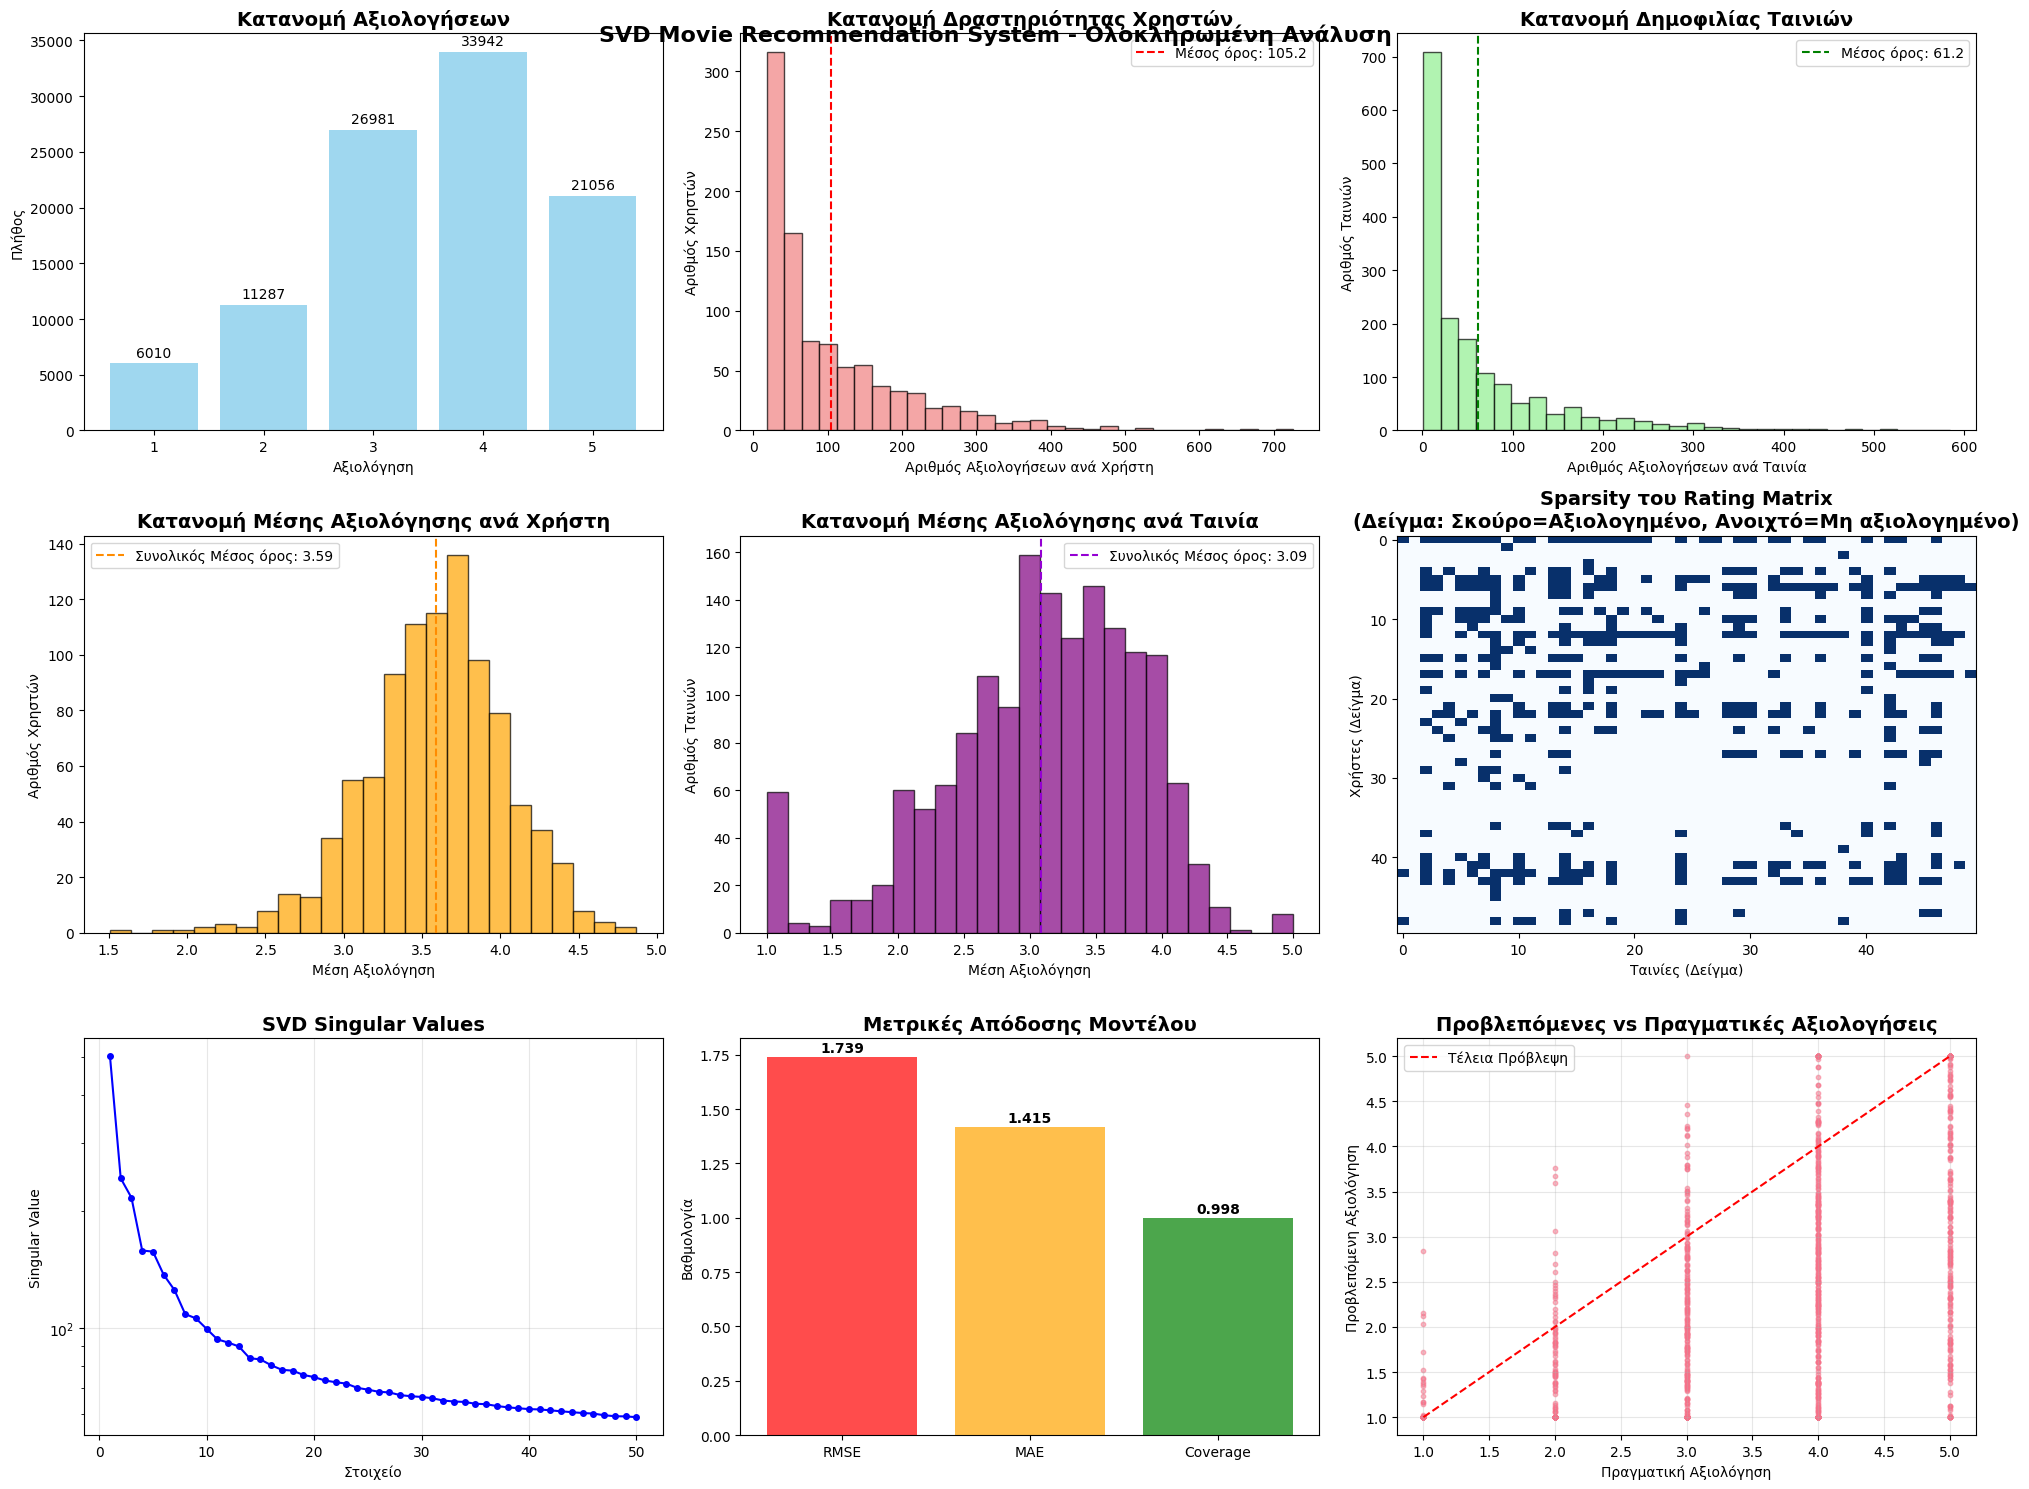

Όλες οι οπτικοποιήσεις δημιουργήθηκαν με επιτυχία!

=== ΣΥΣΤΗΜΑ ΣΥΣΤΑΣΕΩΝ ΤΑΙΝΙΩΝ ΕΤΟΙΜΟ ===
Το σύστημα είναι έτοιμο για χρήση!


In [ ]:
def main():
    """
    Κύρια συνάρτηση για εκτέλεση του συστήματος συστάσεων
    """
    print("=== SVD MOVIE RECOMMENDATION SYSTEM ===")
    print("=== ΣΥΣΤΗΜΑ ΣΥΣΤΑΣΕΩΝ ΤΑΙΝΙΩΝ ΜΕ SVD ===\n")

    data_dir = '/home/achilles/ML-Movie-Recommender/ml-100k/'
    # Αρχικοποίηση συστήματος συστάσεων
    recommender = SVDMovieRecommender(n_factors=50, random_state=42)

    # Βήμα 1: Φόρτωση δεδομένων
    print("Βήμα 1: Φόρτωση MovieLens data...")
    recommender.load_movielens_data(data_dir)
    if recommender.ratings_df is None:
        recommender._create_synthetic_data()
    print("Δεδομένα φορτώθηκαν με επιτυχία!\n")

    # Βήμα 2: Εξερεύνηση δεδομένων
    print("Βήμα 2: Εξερεύνηση δεδομένων...")
    data_stats = recommender.explore_data()
    print("Εξερεύνηση δεδομένων ολοκληρώθηκε!\n")

    # Βήμα 3: Προετοιμασία user-item matrix
    print("Βήμα 3: Προετοιμασία user-item matrix...")
    user_item_matrix = recommender.prepare_matrix(min_ratings_per_user=3, min_ratings_per_movie=3)
    print("Προετοιμασία matrix ολοκληρώθηκε!\n")

    # Βήμα 4: Διαχωρισμός δεδομένων
    print("Βήμα 4: Διαχωρισμός δεδομένων σε train/test sets...")
    train_data, test_data = recommender.split_data(test_size=0.2)
    print("Διαχωρισμός δεδομένων ολοκληρώθηκε!\n")

    # Βήμα 5: Εκπαίδευση SVD model
    print("Βήμα 5: Εκπαίδευση SVD model...")
    predictions_df = recommender.train_svd()
    print("Εκπαίδευση SVD ολοκληρώθηκε!\n")

    # Βήμα 6: Αξιολόγηση model
    print("Βήμα 6: Αξιολόγηση απόδοσης μοντέλου...")
    evaluation_results = recommender.evaluate_model()
    print("Αξιολόγηση μοντέλου ολοκληρώθηκε!\n")

    # Βήμα 7: Δημιουργία συστάσεων
    print("=== ΔΗΜΙΟΥΡΓΙΑ ΣΥΣΤΑΣΕΩΝ ΤΑΙΝΙΩΝ ===\n")

    # Συστάσεις για δείγμα χρηστών
    sample_users = [1, 5, 10, 25, 50]

    for user_id in sample_users:
        if user_id in recommender.predictions_df.index:
            print(f"\n--- Συστάσεις για Χρήστη {user_id} ---")
            recommendations = recommender.get_movie_recommendations(user_id, n_recommendations=10)
            break

    print("\n" + "="*70)
    print("=== ΔΗΜΙΟΥΡΓΙΑ ΟΠΤΙΚΟΠΟΙΗΣΕΩΝ ===\n")

    # Δημιουργία όλων των visualizations
    fig = recommender.create_visualizations()

    print("Όλες οι οπτικοποιήσεις δημιουργήθηκαν με επιτυχία!")

    print("\n=== ΣΥΣΤΗΜΑ ΣΥΣΤΑΣΕΩΝ ΤΑΙΝΙΩΝ ΕΤΟΙΜΟ ===")
    print("Το σύστημα είναι έτοιμο για χρήση!")

    return recommender

main()